# Synthetic Data and Exploratory Data Analysis

## Synthetic Data Generation

- When solving specific business problems, it can be challenging to find sufficient data for traning models. For our project about manpower optimisation in the F&B sector, we adapt the use of synthetic datasets generated by large language models like GPT.

- Although synthetic datasets may not fully capture the real world complexities and may have bias caused by the traning data of the specific LLM(Large Language Model) we use. In the case of our project, synthetic datasets would be the optimal choice to overcome the challenges of real-world data collection, and also generated with specific properties and being representative in our probelm domain.

- We aim to make the synthetic dataset of visitor amount similar to the patterns in the Kaggle datasets(e.g.  peak dates), while also making sure that the vistitor volume corresponds to the capacity of GoodOldDays restaurant.

In [730]:
# import necessary libraries
import g4f
from g4f.Provider import Bing, Liaobots, FlowGpt, ChatgptNext, ChatgptX, ChatgptAi
import re
import datetime
import pandas as pd
import json
import nest_asyncio
nest_asyncio.apply()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [681]:
prompt = """
Produce <<count>> rows of data for time series analysis of a restaurant's visitor data from <<start_date>> to <<end_date>> start and end inclusive, using three columns data frame. First column day_of_week, second column visit_date, third column visitors number of that day. It has visitors mainly from Singapore, China, and India. The public holiday information is as follows: 

1. Singapore: Holidays in 2023: 1 Jan, 2 Jan, 22 Jan, 23 Jan, 24 Jan, 7 Apr, 22 Apr, 1 May, 2 Jun, 29 Jun, 9 Aug, 12 Nov, 13 Nov, 25 Dec; Holidays in 2024: 1 Jan, 10 Feb, 11 Feb, 12 Feb.
2. China:  Holidays in 2023: 01 Jan, 02 Jan, 21 Jan, 22 Jan, 23 Jan, 24 Jan, 25 Jan, 26 Jan, 27 Jan, 05 Apr, 29 Apr, 30 Apr, 01 May, 02 May, 03 May, 22 Jun, 23 Jun, 24 Jun, 29 Sep, 30 Sep, 01 Oct, 02 Oct, 03 Oct, 04 Oct, 05 Oct, 06 Oct; Holidays in 2024: 01 Jan, 10 Feb, 11 Feb, 12 Feb, 13 Feb, 14 Feb, 15 Feb, 16 Feb, 17 Feb.
3. India: Holidays in 2023: 01 Jan, 02 Jan, 22 Jan, 23 Jan, 24 Jan, 07 Apr, 22 Apr, 01 May, 02 Jun, 29 Jun, 09 Aug, 12 Nov, 13 Nov, 25 Dec; Holidays in 2024: 01 Jan, 02 Jan, 11 Jan, 12 Jan, 14 Jan, 15 Jan, 16 Jan, 17 Jan, 23 Jan, 25 Jan, 26 Jan.

Here are the requirements and things to note while producing the examples:
1. The period of year where there are most visitors are April, March, May, and December. 
2. Weekends have most number of visitors. 
3. The date that is holiday in more countries tend to have more visitors. 
4. The restaurant has 100 to 300 visitors during 250 to 500 visitors during public holidays, where visitor at each day is randomly chosen during the reasonable range, while also being affected also by holiday and weekofday factors.

Here is one example entry of output: {"day_of_week": "Monday", "visit_date": "2023-01-01", "visitors": 426}
Output in json format:\n[:
"""

output_df = pd.DataFrame()

In [652]:
def generate_data(start_date, end_date):
    global output_df
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    temp_start_date = start_date
    temp_end_date = temp_start_date + datetime.timedelta(days=29)
    while (temp_end_date < end_date):
        curr_prompt = prompt.replace("<<start_date>>", temp_start_date.strftime('%Y-%m-%d')).replace("<<end_date>>", temp_end_date.strftime('%Y-%m-%d')).replace("<<count>>", "30")
        response = get_response(curr_prompt)
        result = re.findall(r"(\[[^]]+\])", response)
        json_data = json.loads(str(result[0]))
        df = pd.DataFrame(json_data)
        output_df = pd.concat([output_df, df], ignore_index=True)
        temp_start_date += datetime.timedelta(days=30)
        temp_end_date = temp_start_date + datetime.timedelta(days=29)
    # iterate for remaining dates
    count = (end_date - temp_start_date).days
    curr_prompt = prompt.replace("<<start_date>>", temp_start_date.strftime('%Y-%m-%d')).replace("<<end_date>>", end_date.strftime('%Y-%m-%d')).replace("<<count>>", str(count))
    response = get_response(curr_prompt)
    result = re.findall(r"(\[[^]]+\])", response)
    json_data = json.loads(str(result[0]))
    df = pd.DataFrame(json_data)
    output_df = pd.concat([output_df, df], ignore_index=True)

    return output_df
     

def get_response(prompt):
    response = g4f.ChatCompletion.create(
        model=g4f.models.gpt_4,
        messages=[{"role": "user", "content": prompt}],
        provider=Bing,
    )
    return response

generate_data("2024-02-01", "2024-02-29")


Using Bing provider and gpt-4 model


,day_of_week,visit_date,visitors
0,Sunday,2023-01-01,400
1,Monday,2023-01-02,280
2,Tuesday,2023-01-03,150
3,Wednesday,2023-01-04,120
4,Thursday,2023-01-05,110
...,...,...,...
506,Sunday,2024-02-25,465
507,Monday,2024-02-26,105
508,Tuesday,2024-02-27,135
509,Wednesday,2024-02-28,110


In [654]:
output_df.to_csv('../data/raw/synthetic_visit_data.csv', index=False) 

In [662]:
# some manual cleaning as the approach needs some adjustments on df

df = pd.read_csv('../data/raw/synthetic_visit_data.csv')
duplicate_dates = df[df.duplicated('visit_date')]
print(duplicate_dates)

df['day_of_week'] = pd.to_datetime(df['visit_date']).dt.day_name()
df.to_csv('../data/raw/synthetic_visit_data.csv', index=False) 

Empty DataFrame
Columns: [day_of_week, visit_date, visitors]
Index: []


In [728]:
# Add randomness to visitor data to more fit to real world scenario
synthethic_visit_data = pd.read_csv('../data/raw/synthetic_visit_data.csv')
synthethic_visit_data['visitors'] = np.add(synthethic_visit_data['visitors'], np.random.randint(-10, 11, size=425))
synthethic_visit_data.to_csv('../data/raw/synthetic_visit_data.csv', index=False) 

In [733]:
synthethic_visit_data["visit_date"] = pd.to_datetime(synthethic_visit_data["visit_date"]) 

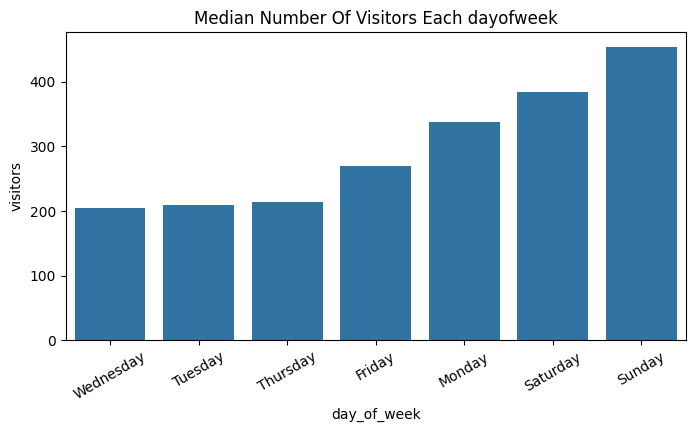

In [734]:
plt.figure(figsize=(8,4))
sns.barplot(data=synthethic_visit_data.groupby("day_of_week")["visitors"].median().reset_index().sort_values("visitors"), x="day_of_week", y="visitors")
plt.xticks(rotation=30)
plt.title("Median Number Of Visitors Each dayofweek")
plt.show()

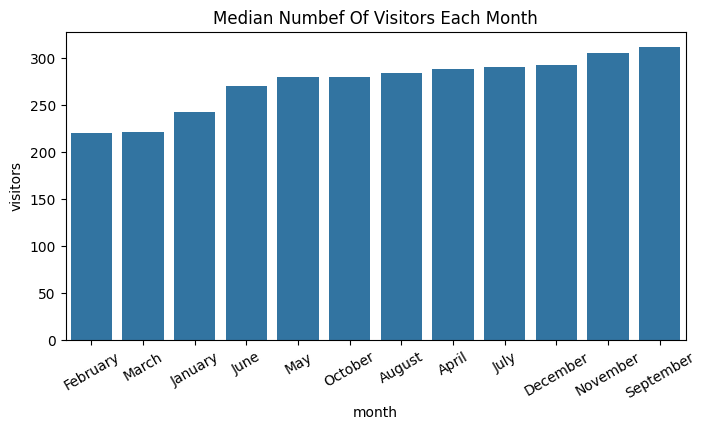

In [735]:
synthethic_visit_data["month"] = [day.month_name() for day in synthethic_visit_data["visit_date"]]
# Plot results
plt.figure(figsize=(8,4))
sns.barplot(data=synthethic_visit_data.groupby("month")["visitors"].median().reset_index().sort_values("visitors"), x="month", y="visitors")
plt.xticks(rotation=30)
plt.title("Median Numbef Of Visitors Each Month")
plt.show()

### Create the dataset of date_info

- The dataset will contain information from 2023 until Feb 2024, and would help us explore the relationship between public holidays and number of visitors.

In [73]:
start_date = datetime.date(2023, 1, 1)
end_date = datetime.date(2024, 2, 29)

holidays_sg= [
    datetime.date(2023, 1, 1), datetime.date(2023, 1, 2), datetime.date(2023, 1, 22),
    datetime.date(2023, 1, 23), datetime.date(2023, 1, 24), datetime.date(2023, 4, 7),
    datetime.date(2023, 4, 22), datetime.date(2023, 5, 1), datetime.date(2023, 6, 2),
    datetime.date(2023, 6, 29), datetime.date(2023, 8, 9), datetime.date(2023, 11, 12),
    datetime.date(2023, 11, 13), datetime.date(2023, 12, 25), datetime.date(2024, 1, 1), 
    datetime.date(2024, 2, 10), datetime.date(2024, 2, 11), datetime.date(2024, 2, 12)
]

holidays_cn= [
    datetime.date(2023, 1, 1), datetime.date(2023, 1, 2), datetime.date(2023, 1, 21),
    datetime.date(2023, 1, 22), datetime.date(2023, 1, 23), datetime.date(2023, 1, 24),
    datetime.date(2023, 1, 25), datetime.date(2023, 1, 26), datetime.date(2023, 1, 27),
    datetime.date(2023, 4, 5), datetime.date(2023, 4, 29), datetime.date(2023, 4, 30),
    datetime.date(2023, 5, 1), datetime.date(2023, 5, 2), datetime.date(2023, 5, 3), 
    datetime.date(2023, 6, 22), datetime.date(2023, 6, 23), datetime.date(2023, 6, 24),
    datetime.date(2023, 9, 29), datetime.date(2023, 9, 30), datetime.date(2023, 10, 1),
    datetime.date(2023, 10, 2), datetime.date(2023, 10, 3), datetime.date(2023, 10, 4),
    datetime.date(2023, 10, 5), datetime.date(2023, 10, 6), datetime.date(2024, 1, 1),
    datetime.date(2024, 2, 10), datetime.date(2024, 2, 11), datetime.date(2024, 2, 12),
    datetime.date(2024, 2, 13), datetime.date(2024, 2, 14), datetime.date(2024, 2, 15),
    datetime.date(2024, 2, 16), datetime.date(2024, 2, 17)
]

holidays_in= [
    datetime.date(2023, 1, 1), datetime.date(2023, 1, 2), datetime.date(2023, 1, 22),
    datetime.date(2023, 1, 23), datetime.date(2023, 1, 24), datetime.date(2023, 4, 7),
    datetime.date(2023, 4, 22), datetime.date(2023, 5, 1), datetime.date(2023, 6, 2),
    datetime.date(2023, 6, 29), datetime.date(2023, 8, 9), datetime.date(2023, 11, 12),
    datetime.date(2023, 11, 13), datetime.date(2023, 12, 25), datetime.date(2024, 1, 1),
    datetime.date(2024, 1, 2), datetime.date(2024, 1, 11), datetime.date(2024, 1, 12),
    datetime.date(2024, 1, 14), datetime.date(2024, 1, 15), datetime.date(2024, 1, 16),
    datetime.date(2024, 1, 17), datetime.date(2024, 1, 23), datetime.date(2024, 1, 25),
    datetime.date(2024, 1, 26)
]



date_info_2324 = []
current_date = start_date
while current_date <= end_date:
    day_of_week = current_date.strftime('%A')
    holiday_flg_sg = 1 if current_date in holidays_sg else 0
    holiday_flg_cn = 1 if current_date in holidays_cn else 0
    holiday_flg_in = 1 if current_date in holidays_in else 0
    date_info_2324.append([current_date.strftime('%Y-%m-%d'), day_of_week, holiday_flg_sg, holiday_flg_cn, holiday_flg_in])
    current_date += datetime.timedelta(days=1)

date_info_2324 = pd.DataFrame(date_info_2324, columns=['calendar_date', 'day_of_week', 'holiday_flg_sg', 'holiday_flg_cn', 'holiday_flg_in'])

In [74]:
date_info_2324

,calendar_date,day_of_week,holiday_flg_sg,holiday_flg_cn,holiday_flg_in
0,2023-01-01,Sunday,1,1,1
1,2023-01-02,Monday,1,1,1
2,2023-01-03,Tuesday,0,0,0
3,2023-01-04,Wednesday,0,0,0
4,2023-01-05,Thursday,0,0,0
...,...,...,...,...,...
420,2024-02-25,Sunday,0,0,0
421,2024-02-26,Monday,0,0,0
422,2024-02-27,Tuesday,0,0,0
423,2024-02-28,Wednesday,0,0,0


In [596]:
date_info_2324.to_csv('../data/raw/date_info_2324.csv', index=False)  

### Add distribution based on weekend and weekdays to generate time-specific visitor arrival info

Some assumptions/conditions to note:
- The restaurant's opening hour is 10 am to 10 pm.
- 6pm - 8pm has higher visitor arrival count due to the event during that time
- We use skewed normal distribution within two time intervals per day to simulate two peaks

In [846]:
import random

opening_time = 10
closing_time = 22
time_intervals = np.arange(opening_time, closing_time)
time_intervals_strings = [f"{hour}-{hour+1}" for hour in time_intervals ]

random.seed(123)

In [849]:
time_intervals_strings

['10-11',
 '11-12',
 '12-13',
 '13-14',
 '14-15',
 '15-16',
 '16-17',
 '17-18',
 '18-19',
 '19-20',
 '20-21',
 '21-22']

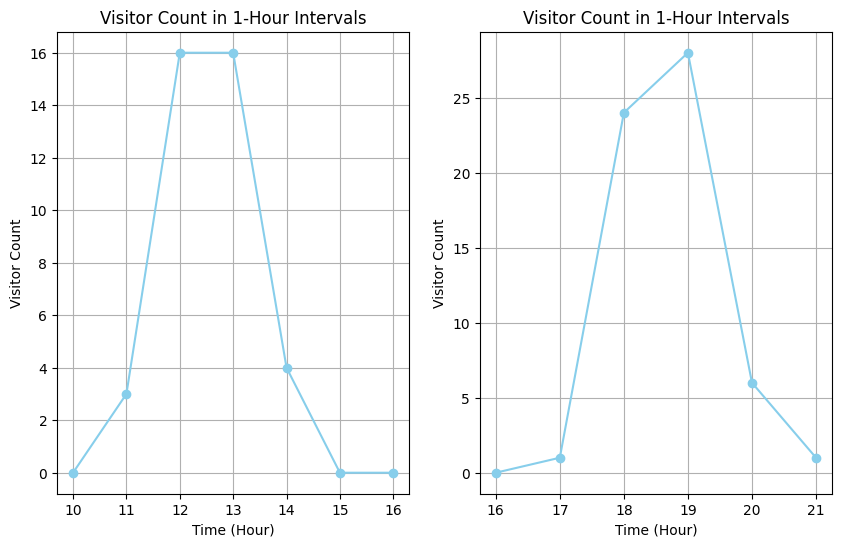

In [813]:
from scipy.stats import skewnorm
time_intervals_1 = np.arange(10, 17)
time_intervals_2 = np.arange(16, 22)

C = 100 # fixed total sum
visitor_counts_1 = skewnorm.pdf(time_intervals_1, a=1, loc=12)
visitor_counts_2 = skewnorm.pdf(time_intervals_2, a=2, loc=18)
visitor_counts_1 = visitor_counts_1 / visitor_counts_1.max()  # Normalize to [0, 1]
visitor_counts_2 = visitor_counts_2 / visitor_counts_2.max()
visitor_counts_1 = np.round(visitor_counts_1 * C*0.4 / visitor_counts_1.sum())
visitor_counts_2 = np.round(visitor_counts_2 * C*0.6 / visitor_counts_2.sum())

# Plot the visitor count data
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(time_intervals_1, visitor_counts_1, marker='o', color='skyblue')
plt.title('Visitor Count in 1-Hour Intervals')
plt.xlabel('Time (Hour)')
plt.ylabel('Visitor Count')
plt.xticks(time_intervals_1)
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(time_intervals_2, visitor_counts_2, marker='o', color='skyblue')
plt.title('Visitor Count in 1-Hour Intervals')
plt.xlabel('Time (Hour)')
plt.ylabel('Visitor Count')
plt.xticks(time_intervals_2)
plt.grid(True)    
plt.show()

Now apply the same approach on our previously generated synthetic_visit_data

In [861]:
def simulate_hourly_arrival(C):    
    visitor_counts_1 = skewnorm.pdf(time_intervals_1, a=1, loc=12)
    visitor_counts_2 = skewnorm.pdf(time_intervals_2, a=2, loc=18)
    visitor_counts_1 = visitor_counts_1 / visitor_counts_1.max()  # Normalize to [0, 1]
    visitor_counts_2 = visitor_counts_2 / visitor_counts_2.max()
    visitor_counts_1 = np.round(visitor_counts_1 * C*0.4 / visitor_counts_1.sum()).astype(int)
    visitor_counts_2 = np.round(visitor_counts_2 * C*0.6 / visitor_counts_2.sum()).astype(int)

    return np.concatenate((visitor_counts_1, visitor_counts_2), axis = None)

In [862]:
synthethic_visit_data = pd.read_csv('../data/raw/synthetic_visit_data.csv')

In [863]:
output_df = pd.DataFrame(columns = ['day_of_week', 'visit_date', 'visitors_daily_total', 'hour_interval', 'visitors_hourly'])

for idx, row in synthethic_visit_data.iterrows():
    hourly_visitors = simulate_hourly_arrival(row['visitors'])
    for i in range(12):
        new_row = pd.DataFrame([{'day_of_week': row['day_of_week'] , 'visit_date': row['visit_date'], 'visitors_daily_total': row['visitors'], 'hour_interval': time_intervals_strings[i], 'visitors_hourly':hourly_visitors[i]}])
        output_df = pd.concat([output_df, new_row], ignore_index=True)

output_df

,day_of_week,visit_date,visitors_daily_total,hour_interval,visitors_hourly
0,Sunday,2023-01-01,409,10-11,0
1,Sunday,2023-01-01,409,11-12,13
2,Sunday,2023-01-01,409,12-13,65
3,Sunday,2023-01-01,409,13-14,67
4,Sunday,2023-01-01,409,14-15,17
...,...,...,...,...,...
5095,Thursday,2024-02-29,134,17-18,0
5096,Thursday,2024-02-29,134,18-19,1
5097,Thursday,2024-02-29,134,19-20,32
5098,Thursday,2024-02-29,134,20-21,38


In [864]:
output_df.to_csv('../data/raw/synthetic_visit_hourly_data.csv', index=False) 

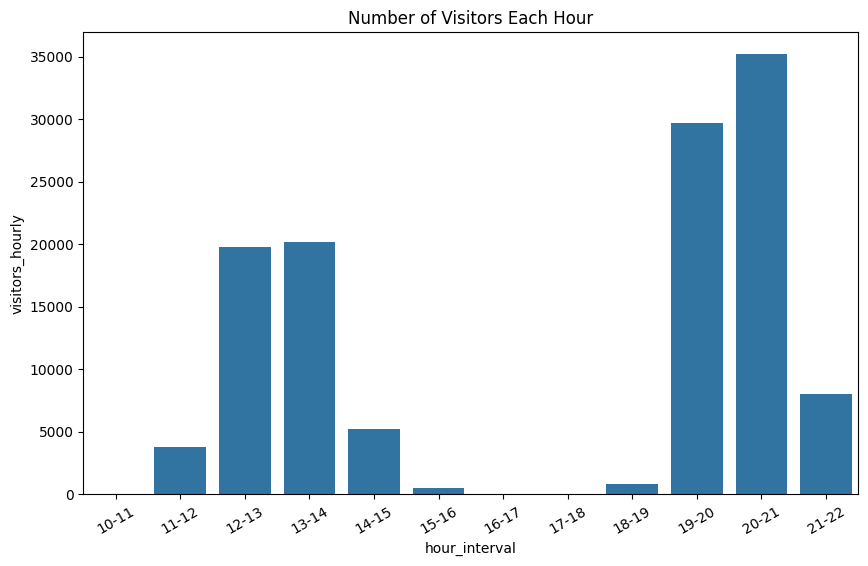

In [866]:
plt.figure(figsize=(10,6))
sns.barplot(data=output_df.groupby(output_df["hour_interval"])["visitors_hourly"].sum().reset_index(), x="hour_interval", y="visitors_hourly")
plt.xticks(rotation=30)
plt.title("Number of Visitors Each Hour")
plt.show()

### Web Scraping of Weather Data

- The dataset will contain information from 2023 until Feb 2024, and would help us explore the relationship between daily weather condition and number of visitors.

In [679]:
base_url = 'http://www.weather.gov.sg/files/dailydata/DAILYDATA_S60_'

# Get all months
all_months = []
for year in range(2023, 2025):
    for month in range(1, 13):
        if (year == 2024 and month == 3):
            break
        all_months.append(f"{year}{month:02d}")

weather_data_df = pd.DataFrame()

for month in all_months:
    curr_month_url = base_url + month + '.csv'
    temp_df = pd.read_csv(curr_month_url)
    weather_data_df = pd.concat([weather_data_df, temp_df], ignore_index=True)
    print(month + " CSV file downloaded successfully")

weather_data_df.to_csv('../data/raw/weather_data.csv', index=False)  

202301 CSV file downloaded successfully
202302 CSV file downloaded successfully
202303 CSV file downloaded successfully
202304 CSV file downloaded successfully
202305 CSV file downloaded successfully
202306 CSV file downloaded successfully
202307 CSV file downloaded successfully
202308 CSV file downloaded successfully
202309 CSV file downloaded successfully
202310 CSV file downloaded successfully
202311 CSV file downloaded successfully
202312 CSV file downloaded successfully
202401 CSV file downloaded successfully
202402 CSV file downloaded successfully


## Exploratory Data Analysis of Generated Data

References
- https://publicholidays.sg/2023-dates/
- https://publicholidays.sg/2024-dates/
- https://publicholidays.cn/2023-dates/
- https://publicholidays.cn/2024-dates/
- https://publicholidays.in/2023-dates/
- https://publicholidays.in/2024-dates/